[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alexa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


STRUCTURA INIȚIALĂ A DATELOR:
     v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  

INFO DATASET:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 

C:\Users\alexa\AppData\Local\Temp\ipykernel_3376\3129903520.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="target", data=df, palette="viridis")


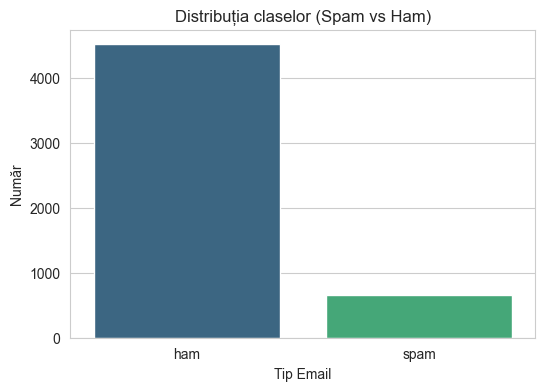


EXEMPLU TEXT CURĂȚAT:
                                                text  \
0  Go until jurong point, crazy.. Available only ...   
1                      Ok lar... Joking wif u oni...   
2  Free entry in 2 a wkly comp to win FA Cup fina...   
3  U dun say so early hor... U c already then say...   
4  Nah I don't think he goes to usf, he lives aro...   

                                          clean_text  
0  go jurong point crazi avail bugi n great world...  
1                              ok lar joke wif u oni  
2  free entri wkli comp win fa cup final tkt st m...  
3                u dun say earli hor u c alreadi say  
4               nah think goe usf live around though  

Dimensiunea matricei de trăsături (X): (5169, 3000)

ÎNCEPERE GRID SEARCH (Poate dura câteva minute)...


KeyboardInterrupt: 

In [1]:
# Import bibliotecile de care am nevoie pentru procesare, ML si grafice
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Descarc stopwords pentru engleza (cuvinte de legatura gen "the", "is")
nltk.download("stopwords")

# Setez un stil mai curat pentru grafice
sns.set_style("whitegrid")

# ==========================================
# 1. PREGATIREA DATELOR
# ==========================================

# Citesc setul de date din fisierul Excel
cale_completa = r"email_spam.xlsx"
df = pd.read_excel(cale_completa)

# Vad cum arata datele la inceput (primele randuri si info general)
print("STRUCTURA INIȚIALĂ A DATELOR:")
print(df.head())
print("\nINFO DATASET:")
print(df.info())

# Scot coloanele 'Unnamed' pentru ca sunt goale si nu ma ajuta cu nimic
df.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], inplace=True)

# Redenumesc coloanele sa fie mai clar ce contin (v1 e targetul, v2 e textul)
df.rename(columns={"v1": "target", "v2": "text"}, inplace=True)

# Verific daca am duplicate si le sterg ca sa nu influenteze modelul aiurea
print(f"\nNumăr duplicate înainte: {df.duplicated().sum()}")
df.drop_duplicates(inplace=True)
print(f"Număr duplicate după eliminare: {df.duplicated().sum()}")

# Transform coloana target din text (ham/spam) in numere (0/1)
le = LabelEncoder()
df["target_encoded"] = le.fit_transform(df["target"])
print("\nMapare Target:", dict(zip(le.classes_, le.transform(le.classes_))))

# Fac un grafic sa vad cat de balansat e datasetul (cate sunt spam vs ham)
plt.figure(figsize=(6, 4))
sns.countplot(x="target", data=df, palette="viridis")
plt.title("Distribuția claselor (Spam vs Ham)")
plt.xlabel("Tip Email")
plt.ylabel("Număr")
plt.show()

# Functia care curata textul de caractere inutile
ps = PorterStemmer()
all_stopwords = stopwords.words("english")

def clean_text(text):
    # Pastrez doar literele, scot cifre si semne
    text = re.sub("[^a-zA-Z]", " ", text)
    # Fac totul cu litere mici
    text = text.lower()
    # Impart textul in cuvinte
    words = text.split()
    # Scot stopwords si aplic stemming (aduc cuvintele la radacina)
    words = [ps.stem(word) for word in words if word not in all_stopwords]
    # Reunesc cuvintele intr-un singur string
    return " ".join(words)


# Aplic functia de curatare pe toata coloana de text
df["clean_text"] = df["text"].apply(clean_text)
print("\nEXEMPLU TEXT CURĂȚAT:")
print(df[["text", "clean_text"]].head())

# Transform textul in vectori numerici folosind TF-IDF
# Iau doar cele mai frecvente 3000 de cuvinte ca sa nu incarc memoria degeaba
tfidf = TfidfVectorizer(max_features=3000) 
X_vectors = tfidf.fit_transform(df["clean_text"]).toarray()

print(f"\nDimensiunea matricei de trăsături (X): {X_vectors.shape}")

# ==========================================
# 2. ANTRENAREA SI EVALUAREA MODELELOR
# ==========================================

# Definesc X (input) si y (output/eticheta)
X = X_vectors
y = df["target_encoded"]

# Impart datele: 80% pentru antrenare si 20% pentru testare
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Aici definesc dictionarul cu modelele pe care vreau sa le testez si hiperparametrii lor
models_params = {
    "Naive Bayes": {"model": MultinomialNB(), "params": {"alpha": [0.1, 1.0, 10.0]}},
    "Support Vector Machine": {
        "model": SVC(),
        "params": {
            "C": [0.1, 1, 10],
            "kernel": ["linear", "rbf"],
            "gamma": ["scale", "auto"],
        },
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "n_estimators": [50, 100],
            "max_depth": [10, None],
            "criterion": ["gini", "entropy"],
        },
    },
}

best_estimators = {}

# Rulez GridSearch pentru fiecare model ca sa gasesc cea mai buna combinatie de parametri
print("\nÎNCEPERE GRID SEARCH (Poate dura câteva minute)...")

for model_name, mp in models_params.items():
    clf = GridSearchCV(
        mp["model"], mp["params"], cv=3, return_train_score=False, n_jobs=-1
    )
    clf.fit(X_train, y_train)

    print(f"\nModel: {model_name}")
    print(f"Cei mai buni hiperparametri: {clf.best_params_}")
    print(f"Cea mai bună acuratețe pe train (CV): {clf.best_score_:.4f}")

    best_estimators[model_name] = clf.best_estimator_

# Trec prin modelele optimizate si le evaluez pe setul de test
plt.figure(figsize=(18, 5))

for i, (model_name, model) in enumerate(best_estimators.items()):
    # Fac predictia
    y_pred = model.predict(X_test)

    # Calculez cat de bine a mers
    acc = accuracy_score(y_test, y_pred)
    print(f"\n================ {model_name} EVALUATION ================")
    print(f"Acuratețe Test: {acc:.4f}")
    print("Raport de clasificare:")
    print(classification_report(y_test, y_pred))

    # Fac matricea de confuzie
    cm = confusion_matrix(y_test, y_pred)

    # O desenez ca un heatmap sa se vada mai clar
    plt.subplot(1, 3, i + 1)
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
        xticklabels=le.classes_,
        yticklabels=le.classes_,
    )
    plt.title(f"{model_name}\nAcc: {acc:.4f}")
    plt.xlabel("Predicție")
    plt.ylabel("Realitate")

plt.tight_layout()
plt.show()